In [1]:
%pip install monai

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


# Naive Classification (2.5D Classification)

Keys inside the file: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)


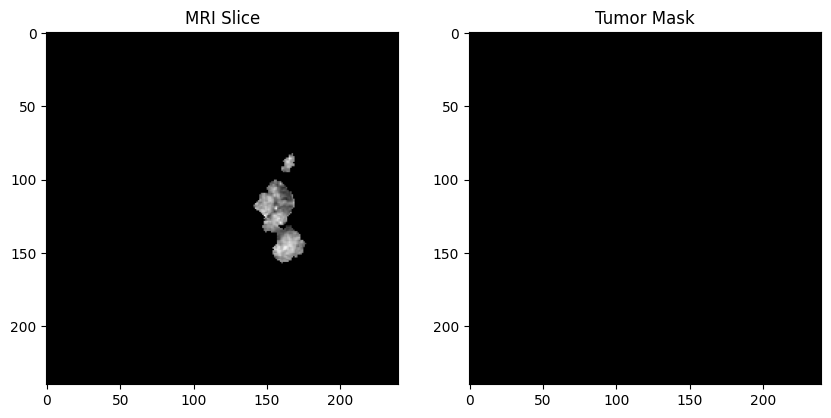

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# UPDATE THIS to the path of one of your files
test_file_path = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data\\volume_1_slice_12.h5" 

if os.path.exists(test_file_path):
    with h5py.File(test_file_path, 'r') as f:
        print("Keys inside the file:", list(f.keys()))
        
        # Let's assume the keys are 'image' and 'mask' (common in this dataset)
        # If the print statement above shows different names, update them below!
        img = f['image'][:]
        mask = f['mask'][:]
        
        print(f"Image shape: {img.shape}")
        print(f"Mask shape: {mask.shape}")

        # Visualize
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img[:,:,2], cmap='gray') # Showing 3rd channel (usually T2 or FLAIR)
        plt.title("MRI Slice")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Tumor Mask")
        plt.show()
else:
    print("File not found. Check your path.")

In [2]:
import glob 
import torch
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose , EnsureChannelFirst, ScaleIntensity, Resize ,ToTensor

class BrainTumorDataset(Dataset):
    def __init__(self,data_dir,transform = None):
        self.files = sorted(glob.glob(os.path.join(data_dir,'*.h5')))
        self.transform = transform
    def __len__(self):
        return len(self.files)  
    def __getitem__(self,idx):
        file_path = self.files[idx]
        with h5py.File(file_path,'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
        image = image.transpose(2,0,1)  # Change to (C, H, W
        
        if mask.ndim == 2:
            mask =mask[None,:,:]
        return {"image":image,"mask":mask}

transforms = Compose([
    ScaleIntensity(),
])

dataset = BrainTumorDataset(data_dir=os.path.dirname(test_file_path), transform=transforms)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
len(dataloader)


7150

# Group Classification (Patient Based)

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

DATA_DIR = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data"
META_FILE = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data\\meta_data.csv"

df = pd.read_csv(META_FILE)

df['filename'] = df['slice_path'].apply(lambda x: os.path.basename(x)) # Get just "volume_41_slice_0.h5"
df['local_path'] = df['filename'].apply(lambda x: os.path.join(DATA_DIR, x))

unique_patients = df['volume'].unique()[:100]  # Limit to first 100 patients for quick testing
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_df = df[df['volume'].isin(train_ids)]
val_df = df[df['volume'].isin(val_ids)]

# train_df = train_df[train_df['target'] == 1] 

print(f"Total {len(unique_patients)}")
print(f"Training {len(train_df)} (from {len(train_ids)} patients)")
print(f"Validation {len(val_df)} (from {len(val_ids)} patients)")

Total 100
Training 12400 (from 80 patients)
Validation 3100 (from 20 patients)


In [5]:
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, ScaleIntensity, EnsureType

class BraTS2DDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get path from DataFrame
        file_path = self.dataframe.iloc[idx]['local_path']
        
        with h5py.File(file_path, 'r') as f:
            img = f['image'][:] 
            mask = f['mask'][:]

        # Fix Image Dimensions: (H, W, C) -> (C, H, W)
        if img.shape[-1] == 4:
            img = np.transpose(img, (2, 0, 1))
            
        # BraTS Label Mapping (Same as before)
        wt = np.logical_or(mask == 1, np.logical_or(mask == 2, mask == 4))
        tc = np.logical_or(mask == 1, mask == 4)
        et = (mask == 4)
        
        label = np.stack([wt, tc, et], axis=0).astype(np.float32)
        img = img.astype(np.float32)

        if self.transform:
            img = self.transform(img)

        return {"image": img, "label": label}

train_transforms = Compose([
    ScaleIntensity(), 
    EnsureType()
])

train_ds = BraTS2DDataset(train_df, transform=train_transforms)
val_ds = BraTS2DDataset(val_df, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

In [6]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)

model.to(device)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convol

In [7]:
from torchsummary import summary
summary(model, input_size=(4, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             592
            Conv2d-2           [-1, 16, 64, 64]             592
       BatchNorm2d-3           [-1, 16, 64, 64]              32
           Dropout-4           [-1, 16, 64, 64]               0
             PReLU-5           [-1, 16, 64, 64]               1
            Conv2d-6           [-1, 16, 64, 64]           2,320
       BatchNorm2d-7           [-1, 16, 64, 64]              32
           Dropout-8           [-1, 16, 64, 64]               0
             PReLU-9           [-1, 16, 64, 64]               1
     ResidualUnit-10           [-1, 16, 64, 64]               0
           Conv2d-11           [-1, 32, 32, 32]           4,640
           Conv2d-12           [-1, 32, 32, 32]           4,640
      BatchNorm2d-13           [-1, 32, 32, 32]              64
          Dropout-14           [-1, 32,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from torch.cuda.amp import GradScaler, autocast # <--- The Secret Sauce
from tqdm import tqdm


BATCH_SIZE = 64  
LR = 1e-4
MAX_EPOCHS = 10


device = torch.device("cuda")
print(f"Training on: {device}")

# 1. Model
model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 2. Loss & Optimizer
loss_function = DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), LR)

# <--- FIX: Use the standard CUDA Scaler
scaler = torch.amp.GradScaler() 

# 3. Optimized Training Loop
for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        
        # <--- FIX: Specify device_type='cuda'
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if step > 0:
        print(f"Epoch {epoch+1} Avg Loss: {epoch_loss/step:.4f}")
    
    torch.save(model.state_dict(), "best_model_amp.pth")

print("✅ Training Complete!")

Training on: cuda


Epoch 1/10:   0%|          | 0/97 [00:00<?, ?batch/s]

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:


import os
import glob
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# MONAI Imports
from monai.transforms import Compose, ScaleIntensity, EnsureType
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from torch.cuda.amp import GradScaler, autocast 

BATCH_SIZE = 256
NUM_WORKERS = 1 
PIN_MEMORY = True     
LR = 1e-4
MAX_EPOCHS = 50


DATA_DIR = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data"
META_FILE = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data\meta_data.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")
print(f"📂 Data Dir Exists: {os.path.exists(DATA_DIR)}")

# %% [markdown]
# ## 2. Data Preparation (Patient-Aware Split)

# %%
# Load Meta Data
df = pd.read_csv(META_FILE)

# %% [markdown]
# ## 2. Data Preparation (Balanced 50/50 Split)

# Fix Paths
df['filename'] = df['slice_path'].apply(lambda x: os.path.basename(x))
df['local_path'] = df['filename'].apply(lambda x: os.path.join(DATA_DIR, x))

# 1. Split by PATIENT first (Critical to prevent leakage)
unique_patients = df['volume'].unique()[:100]
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# 2. Create initial DataFrames
train_df_raw = df[df['volume'].isin(train_ids)]
val_df = df[df['volume'].isin(val_ids)]

# --- ⚖️ BALANCING ACT STARTS HERE ⚖️ ---
# Separate Training data into "Tumor" and "Healthy"
df_tumor = train_df_raw[train_df_raw['target'] == 1]
df_healthy = train_df_raw[train_df_raw['target'] == 0]

# Keep ALL tumor slices, but sample healthy ones to match the count
# This creates a 1:1 ratio (50% Tumor, 50% Healthy)
df_healthy_balanced = df_healthy.sample(n=len(df_tumor), random_state=42)

# Combine and Shuffle
train_df = pd.concat([df_tumor, df_healthy_balanced])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Data Balanced & Ready:")
print(f"   - Original Train Size: {len(train_df_raw)}")
print(f"   - Balanced Train Size: {len(train_df)} (50% Tumor / 50% Healthy)")
print(f"   - Validation Size:     {len(val_df)} (Unbalanced, reflecting real world)")
# %% [markdown]
# ## 3. Custom Dataset Class

class BraTS2DDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['local_path']
        
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

        # 1. Fix Image Shape: (H, W, 4) -> (4, H, W)
        if img.ndim == 3 and img.shape[-1] == 4:
            img = np.transpose(img, (2, 0, 1))
            
        # 2. Fix Mask Shape: Remove extra channels if they exist
        if mask.ndim == 3:
            mask = mask[:, :, 0] # Take first channel
            
        # 3. BINARY MAPPING (The Fix)
        # Instead of 3 channels, we create just 1: "Whole Tumor"
        # Any value > 0 is treated as Tumor
        wt = (mask > 0).astype(np.float32)
        
        # Output shape: (1, H, W)
        label = wt[None, :, :] 
        img = img.astype(np.float32)

        if self.transform:
            img = self.transform(img)

        return {"image": img, "label": label}
# Transforms
train_transforms = Compose([ScaleIntensity(), EnsureType()])

# Instantiate Datasets


🚀 Device: cuda
📂 Data Dir Exists: True
✅ Data Balanced & Ready:
   - Original Train Size: 12400
   - Balanced Train Size: 10658 (50% Tumor / 50% Healthy)
   - Validation Size:     3100 (Unbalanced, reflecting real world)


In [ ]:
import h5py
import numpy as np

# Grab a random file from your dataframe
test_path = train_df.iloc[2]['local_path']

with h5py.File(test_path, 'r') as f:
    mask = f['mask'][:]
    
print(f"File: {test_path}")
print(f"Unique values in mask: {np.unique(mask)}")

File: C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data\volume_92_slice_81.h5
Unique values in mask: [0 1]


In [ ]:
from monai.transforms import NormalizeIntensity

# 1. Use Stronger Normalization (Critical for MRI)
train_transforms = Compose([
    NormalizeIntensity(nonzero=True, channel_wise=True), 
    EnsureType()
])

# Re-create datasets with new transforms
train_ds = BraTS2DDataset(train_df, transform=train_transforms)
val_ds = BraTS2DDataset(val_df, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

# 2. Update Model for Binary Output
model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,          # <--- CHANGED: Only 1 output class (Tumor)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 3. Boost Learning Rate
LR = 1e-3  # <--- Increased from 1e-4 to kickstart learning
optimizer = optim.Adam(model.parameters(), LR)
loss_function = DiceLoss(sigmoid=True)
scaler = torch.amp.GradScaler()

In [ ]:
# %%
# --- 🛡️ SAFE MODE CONFIGURATION 🛡️ ---
LR = .0005        # <--- Back to safe speed (was 1e-3)
MAX_EPOCHS = 30

# 1. Re-Initialize Model (To reset weights from the NaN crash)
model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,          # Binary output
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 2. Loss & Optimizer
# smooth_nr/dr adds a small number to prevent "Divide by Zero" errors
loss_function = DiceLoss(sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5) 
optimizer = optim.Adam(model.parameters(), LR)

# 3. STABLE Training Loop (No AMP/Scaler)
best_metric = 1.0



In [ ]:
for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        # Skip bad files
        if batch_data is None: continue
            
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        
        # Standard Forward Pass (Float32)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        
        # Standard Backward Pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if step > 0:
        avg_loss = epoch_loss / step
        print(f"Epoch {epoch+1} Finished. Avg Loss: {avg_loss:.4f}")
        
        if avg_loss < best_metric:
            best_metric = avg_loss
            torch.save(model.state_dict(), "best_model_unet.pth")
            print("💾 Model Saved!")

print("🎉 Training Complete!")

Epoch 1/30: 100%|██████████| 167/167 [03:53<00:00,  1.40s/batch, loss=0.3871]


Epoch 1 Finished. Avg Loss: 0.4456
💾 Model Saved!


Epoch 2/30: 100%|██████████| 167/167 [02:13<00:00,  1.26batch/s, loss=0.4416]


Epoch 2 Finished. Avg Loss: 0.4426
💾 Model Saved!


Epoch 3/30: 100%|██████████| 167/167 [02:07<00:00,  1.31batch/s, loss=0.5294]


Epoch 3 Finished. Avg Loss: 0.4360
💾 Model Saved!


Epoch 4/30: 100%|██████████| 167/167 [02:10<00:00,  1.27batch/s, loss=0.5003]


Epoch 4 Finished. Avg Loss: 0.4352
💾 Model Saved!


Epoch 5/30: 100%|██████████| 167/167 [02:07<00:00,  1.31batch/s, loss=0.3607]


Epoch 5 Finished. Avg Loss: 0.4060
💾 Model Saved!


Epoch 6/30: 100%|██████████| 167/167 [02:06<00:00,  1.32batch/s, loss=0.2416]


Epoch 6 Finished. Avg Loss: 0.3150
💾 Model Saved!


Epoch 7/30: 100%|██████████| 167/167 [02:33<00:00,  1.08batch/s, loss=0.2461]


Epoch 7 Finished. Avg Loss: 0.3220


Epoch 8/30: 100%|██████████| 167/167 [02:21<00:00,  1.18batch/s, loss=0.2858]


Epoch 8 Finished. Avg Loss: 0.3002
💾 Model Saved!


Epoch 9/30: 100%|██████████| 167/167 [02:30<00:00,  1.11batch/s, loss=0.3134]


Epoch 9 Finished. Avg Loss: 0.2981
💾 Model Saved!


Epoch 10/30: 100%|██████████| 167/167 [02:14<00:00,  1.24batch/s, loss=0.2119]


Epoch 10 Finished. Avg Loss: 0.2826
💾 Model Saved!


Epoch 11/30: 100%|██████████| 167/167 [02:06<00:00,  1.32batch/s, loss=0.2872]


Epoch 11 Finished. Avg Loss: 0.2914


Epoch 12/30: 100%|██████████| 167/167 [02:12<00:00,  1.26batch/s, loss=0.3633]


Epoch 12 Finished. Avg Loss: 0.2959


Epoch 13/30: 100%|██████████| 167/167 [02:06<00:00,  1.32batch/s, loss=0.3061]


Epoch 13 Finished. Avg Loss: 0.2879


Epoch 14/30: 100%|██████████| 167/167 [02:24<00:00,  1.16batch/s, loss=0.2640]


Epoch 14 Finished. Avg Loss: 0.2881


Epoch 15/30: 100%|██████████| 167/167 [02:35<00:00,  1.08batch/s, loss=0.3345]


Epoch 15 Finished. Avg Loss: 0.2931


Epoch 16/30:  23%|██▎       | 38/167 [00:29<01:38,  1.31batch/s, loss=0.3130]

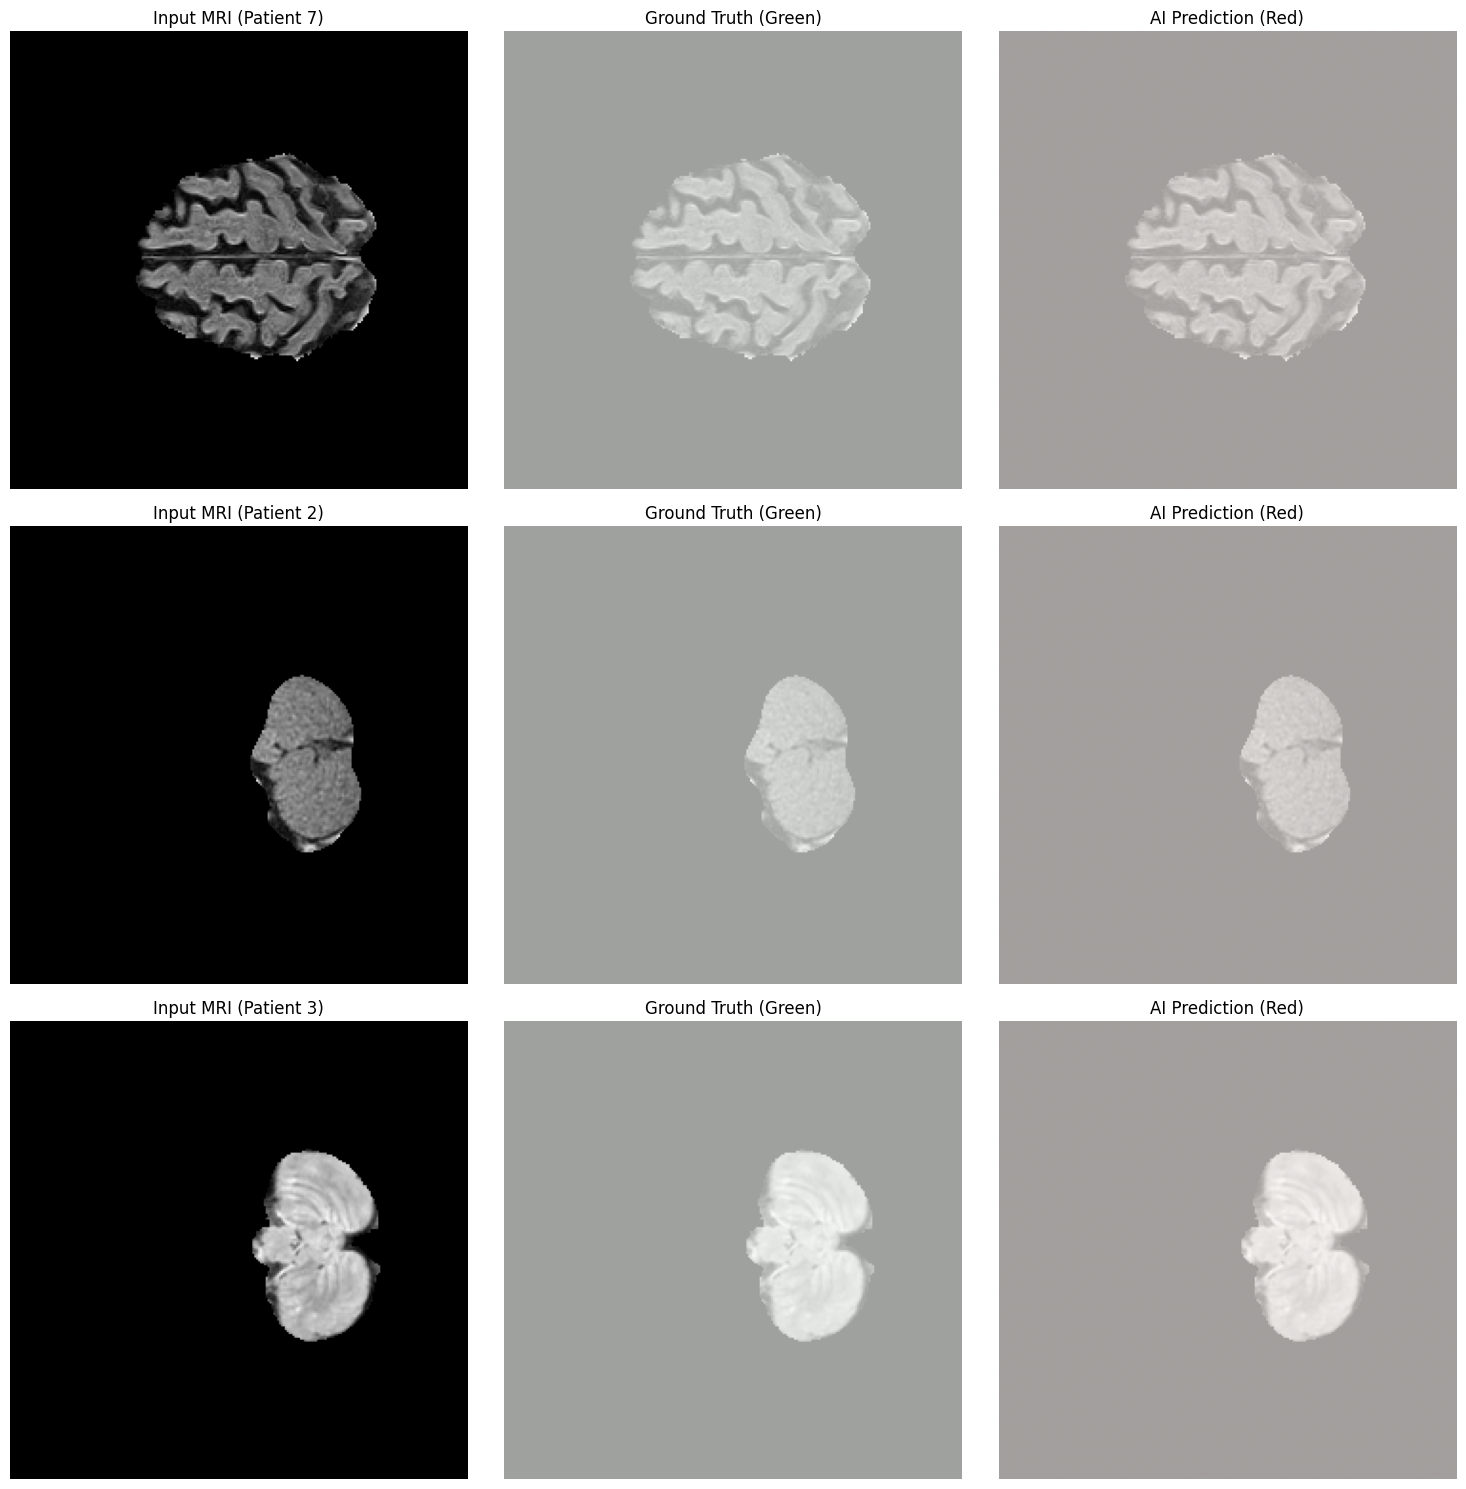

In [13]:
# %% [markdown]
# # 👁️ Visualization: Truth vs. Prediction (Windows Safe Mode)

# %%
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader

# 1. RELOAD THE LOADER SAFELY (Crucial Fix for PicklingError)
# We force num_workers=0 to avoid multiprocessing crashes on Windows
val_loader = DataLoader(
    val_ds, 
    batch_size=8,         # Smaller batch for visualization is fine
    shuffle=True, 
    num_workers=0,        # <--- THE FIX: Run in main process
    pin_memory=True
)

# 2. Load the best model
model.load_state_dict(torch.load("best_model_unet.pth"))
model.eval()

# 3. Get a random batch
# Now this will work because num_workers=0
data_iter = iter(val_loader)
batch = next(data_iter)

images, labels = batch["image"].to(device), batch["label"].to(device)

# 4. Run Inference
with torch.no_grad():
    outputs = model(images)
    # Apply Sigmoid (0..1 range) and Threshold (0.5) to get Binary Mask
    preds = (torch.sigmoid(outputs) > 0.5).float()

# 5. Plot 3 Random Slices from the Batch
# Handle case where batch size is smaller than 3
num_samples = min(3, len(images))
indices = np.random.choice(len(images), num_samples, replace=False)

plt.figure(figsize=(15, 5 * num_samples))

for i, idx in enumerate(indices):
    # Convert tensors to numpy for plotting
    img_np = images[idx, 0, :, :].cpu().numpy()       # Slice 0 (FLAIR)
    lbl_np = labels[idx, 0, :, :].cpu().numpy()       # Ground Truth
    pred_np = preds[idx, 0, :, :].cpu().numpy()       # Prediction

    # Plot Input
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Input MRI (Patient {idx})")
    plt.axis('off')

    # Plot Ground Truth
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(img_np, cmap='gray', alpha=0.6)
    plt.imshow(lbl_np, cmap='Greens', alpha=0.4) # Green = Truth
    plt.title("Ground Truth (Green)")
    plt.axis('off')

    # Plot Prediction
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(img_np, cmap='gray', alpha=0.6)
    plt.imshow(pred_np, cmap='Reds', alpha=0.4)   # Red = AI Prediction
    plt.title("AI Prediction (Red)")
    plt.axis('off')

plt.tight_layout()
plt.show()

🔍 Scanning for 9 tumor examples...


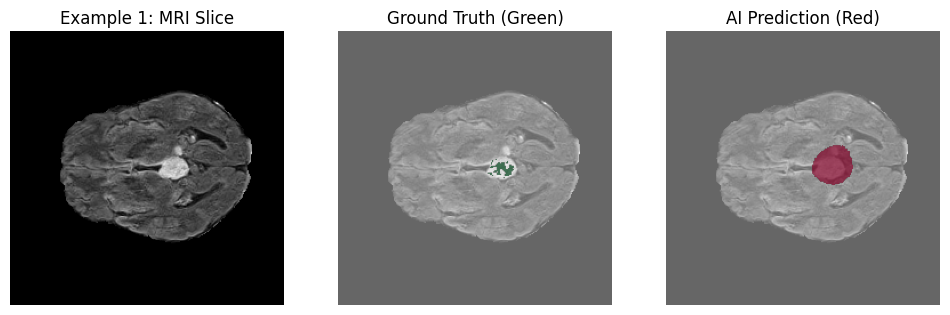

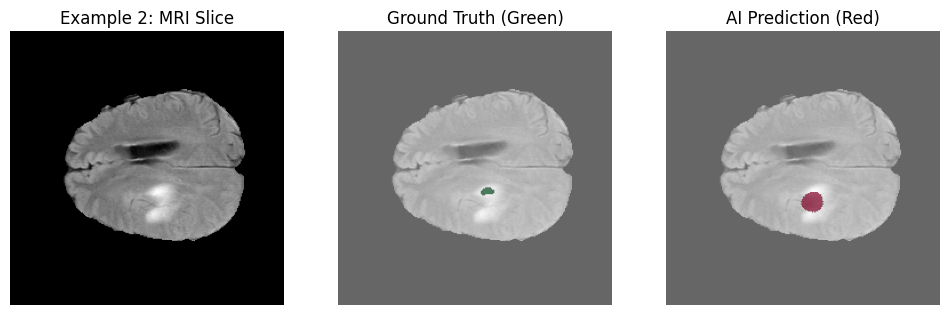

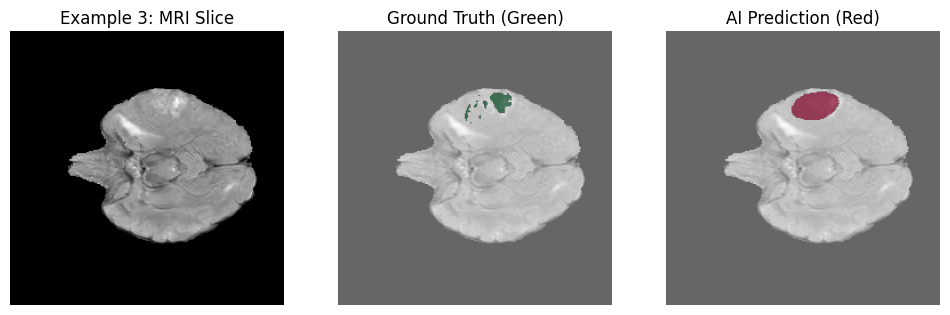

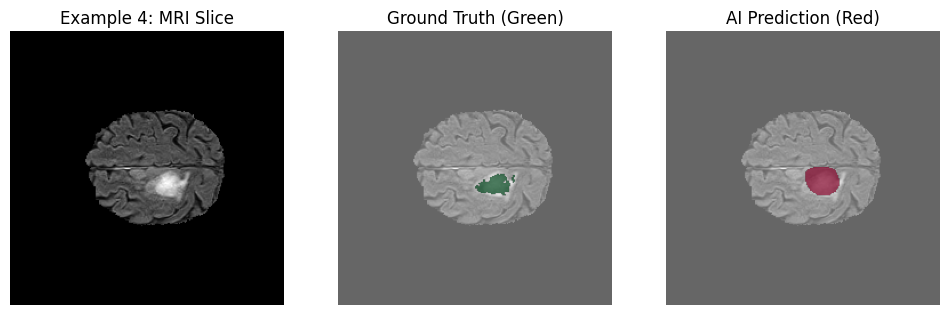

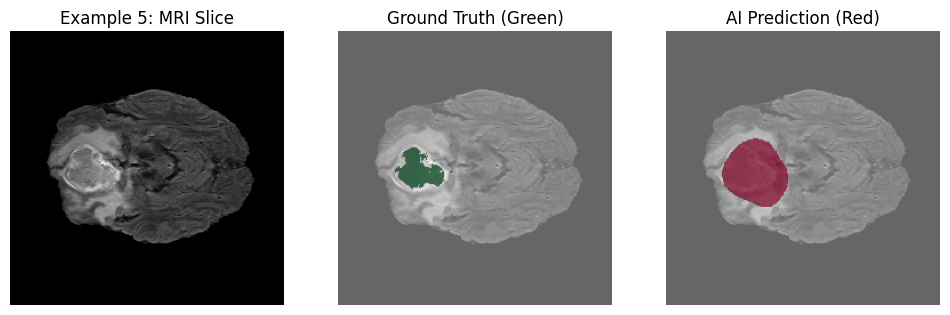

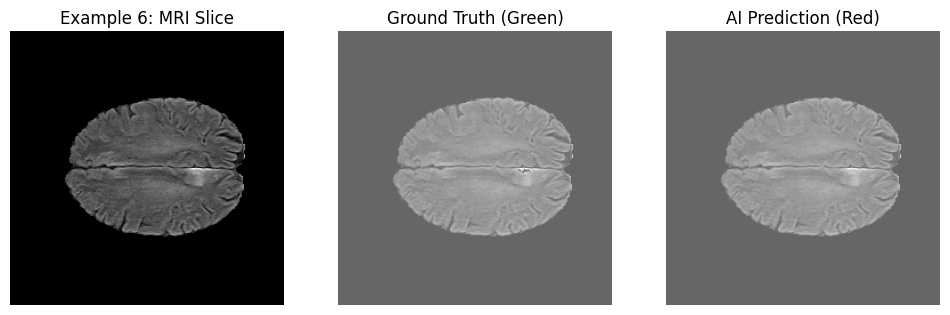

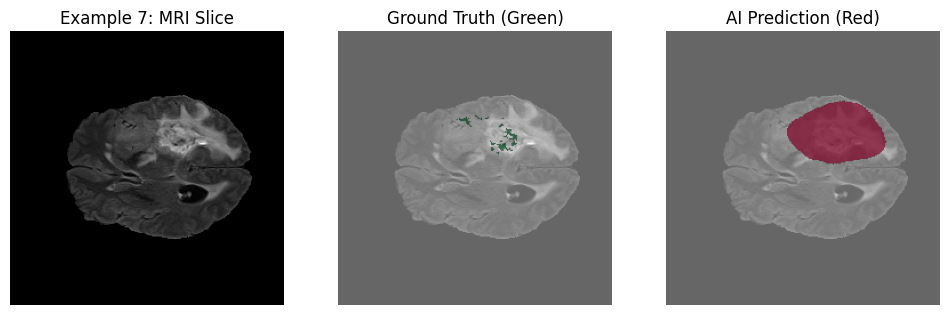

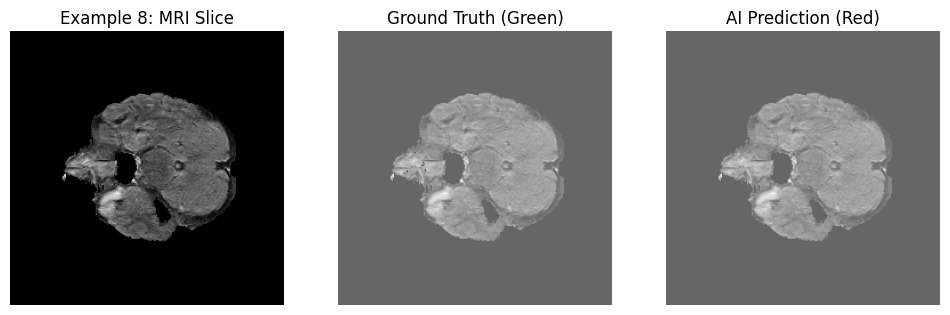

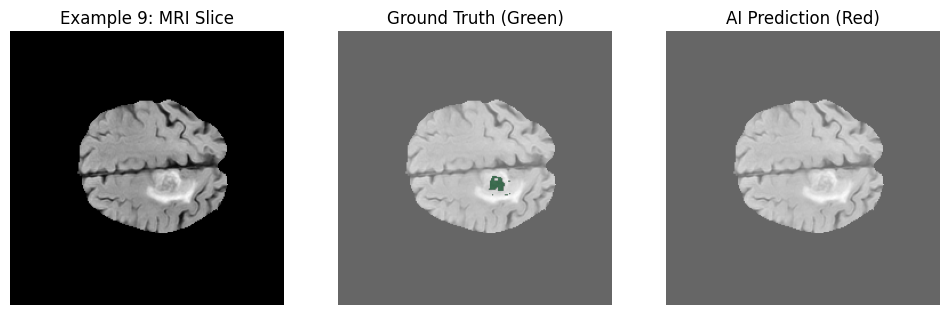

In [14]:
# %% [markdown]
# # 🎯 Visualization: Showing 3 Tumor Examples

# %%
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Setup Loader (Single Process for Windows safety)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)

model.eval()
tumors_found = 0
target_count = 9  # <--- Stop after finding this many

print(f"🔍 Scanning for {target_count} tumor examples...")

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        
        # Check if this slice has a tumor
        if torch.sum(labels) > 0:
            tumors_found += 1
            
            # Run Inference
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Prepare for plotting
            img_np = images[0, 0].cpu().numpy()
            lbl_np = labels[0, 0].cpu().numpy()
            pred_np = preds[0, 0].cpu().numpy()
            
            # PLOT IT
            plt.figure(figsize=(12, 4))
            
            # 1. Input
            plt.subplot(1, 3, 1)
            plt.imshow(img_np, cmap='gray')
            plt.title(f"Example {tumors_found}: MRI Slice")
            plt.axis('off')
            
            # 2. Ground Truth (Green)
            plt.subplot(1, 3, 2)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_lbl = np.ma.masked_where(lbl_np == 0, lbl_np)
            plt.imshow(masked_lbl, cmap='Greens', alpha=0.7, vmin=0, vmax=1)
            plt.title("Ground Truth (Green)")
            plt.axis('off')
            
            # 3. AI Prediction (Red)
            plt.subplot(1, 3, 3)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_pred = np.ma.masked_where(pred_np == 0, pred_np)
            plt.imshow(masked_pred, cmap='YlOrRd', alpha=0.7, vmin=0, vmax=1)
            plt.title("AI Prediction (Red)")
            plt.axis('off')
            
            plt.show()
            
            # Stop if we have found enough
            if tumors_found >= target_count:
                break

if tumors_found == 0:
    print("❌ Found no tumors in the validation set.")

🔍 Searching for a tumor to diagnose...
📊 Statistics for this slice:
   - Max Confidence: 0.9997 (Needs > 0.5 to show red)
   - Min Confidence: 0.1136


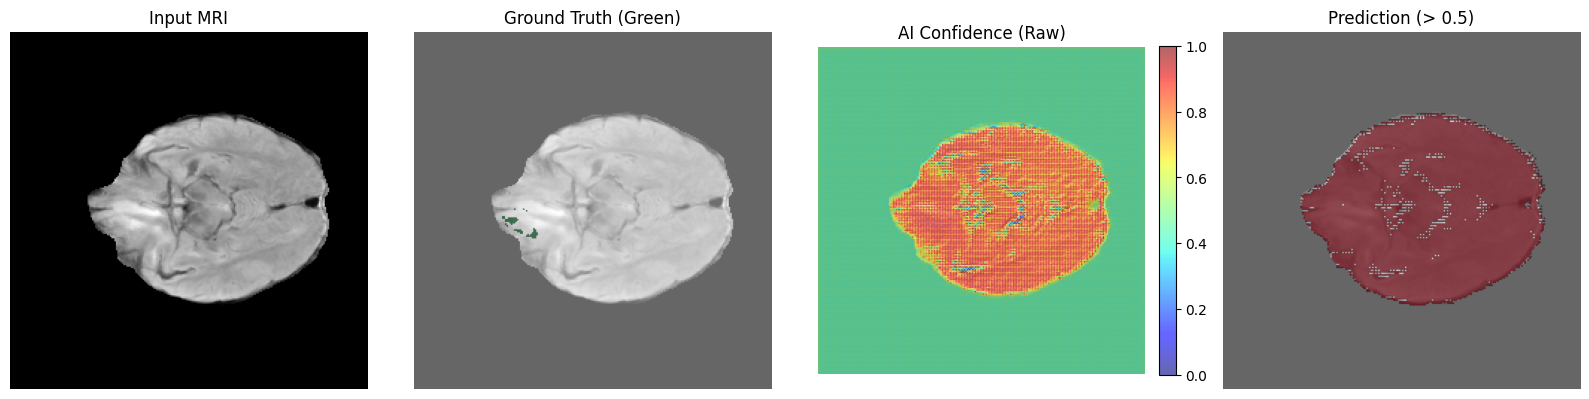

In [ ]:
# %% [markdown]
# # 🔬 Deep Diagnosis: Raw Probability Heatmaps

# %%
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Setup Loader (Single Process)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)

model.eval()
found_interesting_case = False

print("🔍 Searching for a tumor to diagnose...")

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        
        # Only look at slices that ACTUALLY have a tumor
        if torch.sum(labels) > 0:
            
            # Run Inference
            logits = model(images)              # Raw output from U-Net
            probs = torch.sigmoid(logits)       # Convert to Probability (0.0 to 1.0)
            
            # Check statistics
            max_val = probs.max().item()
            min_val = probs.min().item()
            
            # Prepare for plotting
            img_np = images[0, 0].cpu().numpy()
            lbl_np = labels[0, 0].cpu().numpy()
            prob_np = probs[0, 0].cpu().numpy()
            
            print(f"📊 Statistics for this slice:")
            print(f"   - Max Confidence: {max_val:.4f} (Needs > 0.5 to show red)")
            print(f"   - Min Confidence: {min_val:.4f}")
            
            # PLOT IT
            plt.figure(figsize=(16, 5))
            
            # 1. Input MRI
            plt.subplot(1, 4, 1)
            plt.imshow(img_np, cmap='gray')
            plt.title("Input MRI")
            plt.axis('off')
            
            # 2. Ground Truth (Green)
            plt.subplot(1, 4, 2)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_lbl = np.ma.masked_where(lbl_np == 0, lbl_np)
            plt.imshow(masked_lbl, cmap='Greens', alpha=0.7, vmin=0, vmax=1)
            plt.title("Ground Truth (Green)")
            plt.axis('off')
            
            # 3. AI Confidence (Heatmap) <--- THIS IS NEW
            plt.subplot(1, 4, 3)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            # Show probabilities using 'jet' colormap (Blue=Low, Red=High)
            im = plt.imshow(prob_np, cmap='jet', alpha=0.6, vmin=0, vmax=1)
            plt.title("AI Confidence (Raw)")
            plt.axis('off')
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
            # 4. Final Prediction (Thresholded)
            plt.subplot(1, 4, 4)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            # Try a lower threshold (e.g., 0.1) just to see if anything is there
            pred_mask = (prob_np > 0.5).astype(float)
            masked_pred = np.ma.masked_where(pred_mask == 0, pred_mask)
            plt.imshow(masked_pred, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
            plt.title("Prediction (> 0.5)")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Stop after 1 example
            found_interesting_case = True
            break

if not found_interesting_case:
    print("❌ Could not find any slices with tumors.")

In [ ]:

# # 🤖 Model 2: Swin Transformer (SwinUNETR)

# %%
from monai.networks.nets import SwinUNETR
from monai.transforms import Resize, NormalizeIntensity, EnsureType

# --- ⚙️ SWIN CONFIGURATION ⚙️ ---
SWIN_BATCH_SIZE = 24       # Transformers are heavy! 64 might crash. Try 24 or 16.
SWIN_IMG_SIZE = (256, 256) # Must be divisible by 32 (240 is not)
LR_SWIN = 1e-4

# --- 🔄 SWIN TRANSFORMS ---
# We add Resize to ensure the shape fits the Transformer's grid
swin_transforms = Compose([
    NormalizeIntensity(nonzero=True, channel_wise=True),
    Resize(spatial_size=SWIN_IMG_SIZE, mode="bilinear"), # Resize Image
    EnsureType()
])

# For Masks, we must use 'nearest' interpolation to keep values 0 and 1 (no 0.5 floats)
# We need a slightly modified Dataset class to handle different resize modes for img/label
# OR we can just resize the output inside the loop. 
# simpler: Let's update the Dataset class to handle resize if we pass a size.

# Actually, simpler approach: Just resize inside the Dataset class before returning
class BraTS2DSwinDataset(Dataset):
    def __init__(self, dataframe, img_size=(256, 256)):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_size = img_size
        self.resize_img = Resize(img_size, mode="bilinear")
        self.resize_lbl = Resize(img_size, mode="nearest") # Critical for masks!

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['local_path']
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

        if img.ndim == 3 and img.shape[-1] == 4: img = np.transpose(img, (2, 0, 1))
        if mask.ndim == 3: mask = mask[:, :, 0]
            
        # Binary Label
        wt = (mask > 0).astype(np.float32)
        label = wt[None, :, :] 
        img = img.astype(np.float32)

        # --- RESIZE FOR SWIN ---
        # MONAI transforms expect channel-first input
        img = self.resize_img(img)
        label = self.resize_lbl(label)
        
        # Normalize
        scaler = ScaleIntensity()
        img = scaler(img)

        return {"image": img, "label": label}

# Create Swin Loaders
train_ds_swin = BraTS2DSwinDataset(train_df, img_size=SWIN_IMG_SIZE)
val_ds_swin = BraTS2DSwinDataset(val_df, img_size=SWIN_IMG_SIZE)

train_loader_swin = DataLoader(train_ds_swin, batch_size=SWIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader_swin = DataLoader(val_ds_swin, batch_size=SWIN_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("✅ Swin Data Loaders Ready (256x256).")

✅ Swin Data Loaders Ready (256x256).


In [15]:
# %%
from monai.networks.nets import SwinUNETR
import torch.optim as optim
from monai.losses import DiceLoss
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Configuration from previous step
SWIN_IMG_SIZE = (256, 256)
LR_SWIN = 1e-4

# 1. Initialize SwinUNETR (Corrected)
model2 = SwinUNETR(
    # img_size=SWIN_IMG_SIZE, <--- REMOVED THIS LINE
    in_channels=4,
    out_channels=1,
    feature_size=24,         # Use 24 for 8GB VRAM (or 48 if you have 12GB+)
    use_checkpoint=True,     # Saves memory
    spatial_dims=2           # 2D Mode
).to(device)

# 2. Setup Optimizer & Loss
optimizer2 = optim.AdamW(model2.parameters(), lr=LR_SWIN, weight_decay=1e-5)
loss_function = DiceLoss(sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5)
scaler = torch.amp.GradScaler('cuda')

# Checkpoints for Model 2
CHECKPOINT_SWIN = "checkpoint_swin.pth"
BEST_MODEL_SWIN = "best_model_swin.pth"

print("✅ Swin Model Initialized Correctly!")

✅ Swin Model Initialized Correctly!


In [ ]:
model2.load_state_dict(torch.load(BEST_MODEL_SWIN))

<All keys matched successfully>

In [ ]:
MAX_EPOCHS=20


In [ ]:
best_metric_swin = 1.0
# --- 🛡️ STABILIZED SWIN CONFIGURATION 🛡️ ---
LR_SWIN = 2e-5   # <--- Lowered from 1e-4 (Swin needs gentle starts)
MAX_EPOCHS = 20

# Re-init optimizer with new LR
optimizer2 = optim.AdamW(model2.parameters(), lr=LR_SWIN, weight_decay=1e-5)

print("🚀 Restarting Swin Training with Gradient Clipping...")

for epoch in range(MAX_EPOCHS):
    model2.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader_swin, desc=f"Swin Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        if batch_data is None: continue
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer2.zero_grad()
        
        # Mixed Precision
        with torch.amp.autocast('cuda'):
            outputs = model2(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        
        # --- 🛡️ THE FIX: GRADIENT CLIPPING 🛡️ ---
        # Unscale gradients first (required when using scaler)
        scaler.unscale_(optimizer2)
        # Clip gradients to max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        
        scaler.step(optimizer2)
        scaler.update()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / step
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
    
    if avg_loss < best_metric_swin:
        best_metric_swin = avg_loss
        torch.save(model2.state_dict(), BEST_MODEL_SWIN)
        print(f"💎 New Best Swin Model Saved! ({best_metric_swin:.4f})")

Swin Epoch 1/20:   0%|          | 0/445 [00:00<?, ?batch/s]

Swin Epoch 1/20: 100%|██████████| 445/445 [07:03<00:00,  1.05batch/s, loss=0.5531]


Epoch 1 Avg Loss: 0.7316
💎 New Best Swin Model Saved! (0.7316)


Swin Epoch 2/20: 100%|██████████| 445/445 [07:00<00:00,  1.06batch/s, loss=0.5188]


Epoch 2 Avg Loss: 0.7299
💎 New Best Swin Model Saved! (0.7299)


Swin Epoch 3/20: 100%|██████████| 445/445 [08:22<00:00,  1.13s/batch, loss=0.5916]


Epoch 3 Avg Loss: 0.7302


Swin Epoch 4/20: 100%|██████████| 445/445 [05:24<00:00,  1.37batch/s, loss=1.0000]


Epoch 4 Avg Loss: 0.7310


Swin Epoch 5/20: 100%|██████████| 445/445 [04:31<00:00,  1.64batch/s, loss=1.0000]


Epoch 5 Avg Loss: 0.7303


Swin Epoch 6/20: 100%|██████████| 445/445 [04:33<00:00,  1.63batch/s, loss=1.0000]


Epoch 6 Avg Loss: 0.7301


Swin Epoch 7/20: 100%|██████████| 445/445 [04:58<00:00,  1.49batch/s, loss=1.0000]


Epoch 7 Avg Loss: 0.7296
💎 New Best Swin Model Saved! (0.7296)


Swin Epoch 8/20: 100%|██████████| 445/445 [05:01<00:00,  1.48batch/s, loss=1.0000]


Epoch 8 Avg Loss: 0.7290
💎 New Best Swin Model Saved! (0.7290)


Swin Epoch 9/20:  24%|██▍       | 108/445 [01:12<03:31,  1.60batch/s, loss=0.7039]